Program to check if a photo is of a national park, and whether the photo is of a bird.

### 1. Download images of birds and non-birds



In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

#### Getting URLs of bird photos

In [2]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'https://www.highreshdwallpapers.com/wp-content/uploads/2014/05/Colourful-Flying-Bird.jpg'

#### Using the URL to download a photo and then opening it

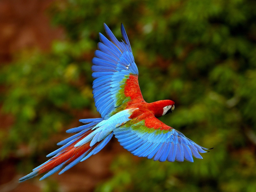

In [8]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)
    

Searching for 'forest photos'


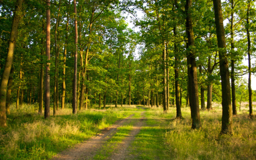

In [7]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [10]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


### Training the model

In [12]:
# Removing files that may not have been downloaded correctly

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

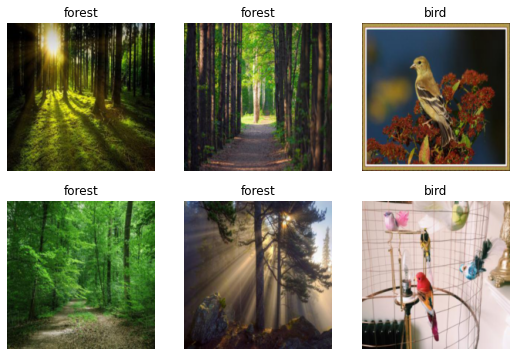

In [14]:
# DataLoaders is an object which contains a training set and a validation set. 
# We create that in fast.ai using a DataBlock

dls = DataBlock(
    # inputs are images, outputs are categories
    blocks=(ImageBlock, CategoryBlock), 
    # get all inputs (list of all image files in a path)
    get_items=get_image_files, 
    # split the data into training and validation sets (20% data for validation)
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # y values are the name of the folder they're in
    get_y=parent_label,
    # all images need to be of the same size
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [15]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/drunken-glover/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/drunken-glover/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/drunken-glover/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.771715,0.681494,0.279070,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.198471,0.060428,0.000000,00:02
1,0.113215,0.041932,0.023256,00:02
2,0.072806,0.018764,0.000000,00:02


### Using the model

In [16]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
